In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import MC
import time
import pickle
import datetime
import Sensor
%autoreload 2

In [7]:
def runTest():
    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7]
                                )
    print(ret[1], ret[2], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1],
          'num_detected': ret[2]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
def runTargetTest():
    t1 = time.perf_counter()
    target_mask = np.zeros(shape=(60,60))
    target_mask[21:50,28:32]=1
    #target_mask[15:45,15:19]=1
    target_mask[16:21,15:45]=1
    target_gridsize = np.array([1,1])
    target_distance_from_camera = 10
    
#     plt.figure()
#     plt.imshow(target_mask)
#     plt.title('Simulating Target')
#     plt.show()
    
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7],
                                target = {'type':1,
                                'mask':target_mask,
                                'grid_size':target_gridsize,
                                'z_target':target_distance_from_camera}
                                )
    print(ret[1], ret[2], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1],
          'num_detected': ret[2]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
def loadTest():
    with open('testdata.pickle', 'rb') as handle:
        ds = pickle.load(handle)

    data = ds['data']
    num_simulated = ds['num_simulated']
    num_detected = ds['num_detected']

    return data, num_simulated, num_detected

def plotTest(data):
    plt.figure(figsize=(20,7))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.hist(data[:,i], bins=100)
    plt.show()
        
def plotTargetTest(data):
    data = data[:,[2,3,0]]
    measurement = Sensor.photonsTo3DMeasurement(data,camera = {'center': [0,0],'dim':[64,64],
                                                                'pixel_size':1, 'time_res':50,
                                                                'time_bin':100})
    measurement_xy = np.sum(measurement,axis=2)
    measurement_xt = np.sum(measurement,axis=0)
    ft = np.sum(measurement_xt,axis=0)
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.imshow(measurement_xy)
    plt.subplot(132)
    plt.imshow(measurement_xt)
    plt.subplot(133)
    plt.plot(ft)
    plt.show()
        
def testRun():
    print(datetime.datetime.now())
    runTest()
    data, num_simulated, num_detected = loadTest()
    plotTest(data)


def testRunTarget():
    print(datetime.datetime.now())
    runTargetTest()
    data, num_simulated, num_detected = loadTest()
    plotTargetTest(data)



2019-02-06 11:09:07.739204
10000000 6474580 15.856996188056655
10000000 6474580 15.857190351001918


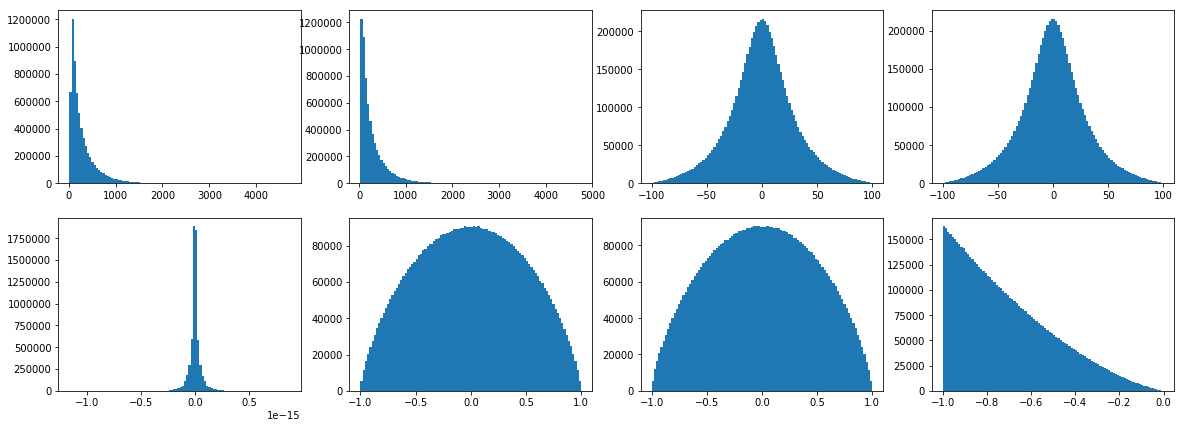

In [20]:
testRun()

#### Test after adding 2D target simulation feature

In [ ]:
testRun()

2019-02-07 17:26:31.415040


2019-02-07 17:23:48.809648
10000000 195381 135.51662326301448


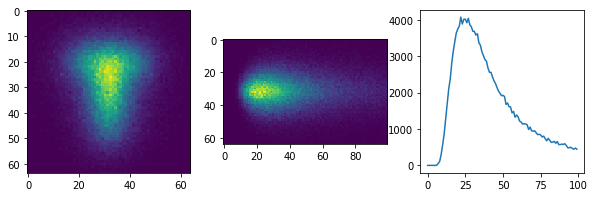

In [6]:
testRunTarget()